In [50]:
import copy

import pandas as pd
import numpy as np
import os

In [51]:
# 添加验证集和测试集
train_df = pd.read_csv('../../UJIIndoorLoc/trainingData.csv')
train_df_noisy = pd.read_csv('../../data/train_noisy.csv')
train_df_noisy1 = pd.read_csv('../../data/train_noisy1.csv')
train_df_noisy2 = pd.read_csv('../../data/train_noisy2.csv')
# train_df_noisy3 = pd.read_csv('../data/train_noisy3.csv')
train_df_noisy4 = pd.read_csv('../../data/train_noisy4.csv')
train_df_noisy5 = pd.read_csv('../../data/train_noisy5.csv')

# train_df = pd.concat([train_df, train_df_noisy4], ignore_index=True)
train_df = pd.concat([train_df, train_df_noisy1], ignore_index=True)
# train_df = pd.concat([train_df, train_df_noisy2], ignore_index=True)
# train_df = pd.concat([train_df, train_df_noisy5], ignore_index=True)
valid_df = pd.read_csv('../../UJIIndoorLoc/validationData.csv')

total_df = pd.concat([train_df, valid_df])

In [52]:
# 训练集特征
training_data = train_df[train_df.columns[:520]].to_numpy()
# training_data[training_data == 100] = -110
training_floors = train_df['FLOOR'].to_numpy() # FLOOR LABELS
training_buildings = train_df['BUILDINGID'].to_numpy() # BUILDING LABELS
training_longitude = train_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
training_latitude = train_df['LATITUDE'].to_numpy() # LATITUDE LABELS
training_coords = train_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS
print(training_coords[0])

[  -7541.2643 4864920.7782]


In [53]:
# 验证机特征
valid_data = valid_df[valid_df.columns[:520]].to_numpy()
# valid_data[valid_data == 100] = -110
valid_floors = valid_df['FLOOR'].to_numpy() # FLOOR LABELS
valid_buildings = valid_df['BUILDINGID'].to_numpy() # BUILDING LABELS
valid_longitude = valid_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
valid_latitude = valid_df['LATITUDE'].to_numpy() # LATITUDE LABELS
valid_coords = valid_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS

In [54]:
totaling_data = total_df[total_df.columns[:520]].to_numpy()
# totaling_data[totaling_data == 100] = -110
totaling_floors = total_df['FLOOR'].to_numpy() # FLOOR LABELS
totaling_buildings = total_df['BUILDINGID'].to_numpy() # BUILDING LABELS
totaling_longitude = total_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
totaling_latitude = total_df['LATITUDE'].to_numpy() # LATITUDE LABELS
totaling_coords = total_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS

In [55]:
# from sklearn.preprocessing import StandardScaler
# from Algorithms.utill.ELM import ELM_AE
# # 2. 标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(training_data)
# 
# # 3. ELM降维
# elm_ae = ELM_AE(input_dim=training_data.shape[1], hidden_dim=256)
# training_data = elm_ae.fit_transform(X_scaled)
# 
# print(training_data[0])
# print(totaling_coords[0])

In [56]:
from Algorithms.utill.data_standar import normalize_rssi, normalize_coords, normalize_test_or_valid_data
# 数据标准化,从总数居获取最大值最小值
X_totalCo_cnn, X_min, X_max = normalize_rssi(totaling_data)
print(X_min, X_max)
# 训练集特征标准化
training_data = normalize_test_or_valid_data(X_min, X_max, training_data)
# 验证集特征标准化
valid_data = normalize_test_or_valid_data(X_min, X_max, valid_data)
# 训练集经度标签标准化
print(training_coords[0])
training_latitude, y_min_la, y_max_la = normalize_coords(totaling_latitude, training_latitude)
# 验证集经度标签标准化
valid_latitude, y_va_min_la, y_va_max_la = normalize_coords(totaling_latitude, valid_latitude)
# 训练集纬度标签标准化
print(training_coords[0])
training_longitude, y_min_lo, y_max_lo = normalize_coords(totaling_longitude, training_longitude)
# 验证集纬度标签标准化
valid_longitude, y_va_min, y_va_max = normalize_coords(totaling_longitude, valid_longitude)
# 保存的最大，最小值
print(y_min_la, y_max_la, y_min_lo, y_max_lo)
min_max_dist = [y_min_la, y_max_la, y_min_lo, y_max_lo]

-105.41166034560202 100.0
[  -7541.2643 4864920.7782]
[  -7541.2643 4864920.7782]
4864745.745015971 4865017.364684202 -7695.93875492993 -7299.786516730871


In [57]:
print(training_data.shape)

(39874, 520)


In [58]:
# Augmenting data shape to fit 23x23
training_data_aug = np.empty((len(training_data),529))
for x in range(len(training_data)):
    training_data_aug[x] = np.concatenate((training_data[x], np.full(shape=9,fill_value=1)))
# Augmenting data shape to fit 23*23
valid_data_aug = np.empty((len(valid_data),529))
for x in range(len(valid_data)):
    valid_data_aug[x] = np.concatenate((valid_data[x], np.full(shape=9,fill_value=1)))
# valid_data_aug.shape
# training_data_aug = training_data

In [59]:
# 经度处理
from sklearn.model_selection import train_test_split
#  准备数据
X = training_data_aug.reshape(len(training_data_aug), 23, 23)
y = training_latitude
z = train_df['SPACEID'].to_numpy()  # 分层标签

assert len(X) == len(y) == len(z), (len(X), len(y), len(z))

# 第一步：先切 20% 测试集
X_temp_la, X_test_la_cnn, y_temp_la, y_test_la_cnn, stratify_temp_la, stratify_test_la = train_test_split(
    X, y, z,
    test_size=0.2,               # 20% → 测试
    random_state=2812,
    stratify=z
)

# 第二步：在剩下的 80% 里切 10% 验证 (0.8 * 1/8 = 0.1)
X_train_la_cnn, X_valid_la_cnn, y_train_la_cnn, y_valid_la_cnn = train_test_split(
    X_temp_la, y_temp_la,
    test_size=1/8,               # 10% → 验证
    random_state=2812,
    stratify=stratify_temp_la
)



In [60]:
# 纬度处理
from sklearn.model_selection import train_test_split
#  准备数据
X = training_data_aug.reshape(len(training_data_aug), 23, 23)
y = training_longitude
z = train_df['SPACEID'].to_numpy()  # 分层标签

assert len(X) == len(y) == len(z), (len(X), len(y), len(z))

# 第一步：先切 20% 测试集
X_temp_lo, X_test_lo_cnn, y_temp_lo, y_test_lo_cnn, stratify_temp_lo, stratify_test_lo = train_test_split(
    X, y, z,
    test_size=0.2,               # 20% → 测试
    random_state=2812,
    stratify=z
)

# 第二步：在剩下的 80% 里切 10% 验证 (0.8 * 1/8 = 0.1)
X_train_lo_cnn, X_valid_lo_cnn, y_train_lo_cnn, y_valid_lo_cnn = train_test_split(
    X_temp_lo, y_temp_lo,
    test_size=1/8,               # 10% → 验证
    random_state=2812,
    stratify=stratify_temp_lo
)

In [61]:
# from sklearn.model_selection import train_test_split
# 
# train_space_ids = train_df['SPACEID'].values
# X_train_la_cnn, X_test_la_cnn, y_train_la_cnn, y_test_la_cnn = train_test_split(training_data_aug.reshape(len(training_data_aug),23,23), training_latitude, test_size=0.2, random_state=2812,stratify=train_space_ids)
# # X_trainCo_cnn, y_trainCo_cnn = training_data_aug.reshape(len(training_data_aug),23,23), training_coords
# X_valid_la_cnn, y_valid_la_cnn = valid_data_aug.reshape(len(valid_data_aug),23,23), valid_latitude
# 
# 
# valid_ids =  valid_df['SPACEID'].values
# # 只取纬度作为训练
# X_train_lo_cnn, X_test_lo_cnn, y_train_lo_cnn, y_test_lo_cnn = train_test_split(training_data_aug.reshape(len(training_data_aug),23,23), training_longitude, test_size=0.2, random_state=2812, stratify=train_space_ids)
# # X_trainCo_cnn, y_trainCo_cnn = training_data_aug.reshape(len(training_data_aug),23,23), training_coords
# X_valid_lo_cnn, y_valid_lo_cnn = valid_data_aug.reshape(len(valid_data_aug),23,23), valid_longitude

In [62]:
print(y_train_la_cnn[:5])
print(y_test_la_cnn[:5])
print(y_train_lo_cnn[:5])
print(y_test_lo_cnn[:5])

[0.22083115 0.64440394 0.29282373 0.25023918 0.22978448]
[0.05350294 0.14914304 0.50588378 0.25023918 0.44562341]
[0.96960011 0.39044398 0.90425503 0.95688354 0.73482623]
[0.83985521 0.75911613 0.66512474 0.95688354 0.33762918]


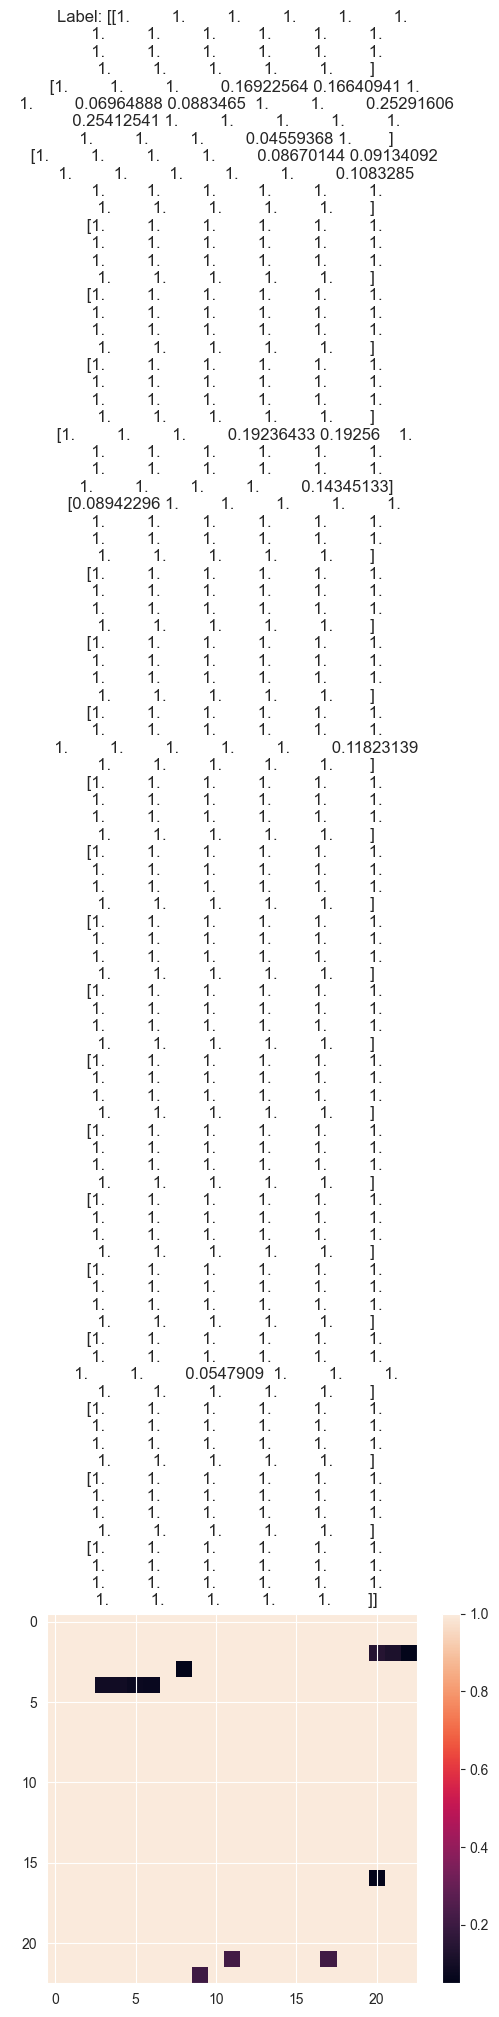

In [63]:
import matplotlib.pyplot as plt
single_image = X_train_la_cnn[0]
plt.imshow(single_image)
plt.title(f'Label: {X_valid_la_cnn[0]}')
plt.colorbar()
plt.show()

In [64]:
from Algorithms.CNN import CNNRegressor
from Algorithms.utill.data_standar import denormalize_coords, mean_euclidean_distance

In [65]:
# Longitude+Latitude Regressor
dropout = [0.3,0.4,0.5]
lrs = [0.0001]
kernel_sizes = [3,5,7]
strides = [1]
model_order = 82
weight_decays = [0.001, 0.0001]
for val in dropout:
    for lr in lrs:
        for kernel_size in kernel_sizes:
            for stride in strides:
                for weight_decay in weight_decays:
                    padding = 0
                    print(f'(Dropout: {val}) (kernel: {kernel_sizes}) (padding: {padding}) (lr:{lr})')
                    cnn = CNNRegressor(n_targets=1, dropout=val, kernel_size=kernel_size, stride = stride, padding=padding) # Longitude + Latitude are targets
                    cnn.fit(X_train_lo_cnn, y_train_lo_cnn, X_test_lo_cnn, y_test_lo_cnn)
                    # cnn.fit(X_trainCo_cnn, y_trainCo_cnn_scaled, X_testCo_cnn, y_testCo_cnn_scaled)
                    # cnn.train(num_epochs=100,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=16)
                    cnn.train_model(num_epochs=100,eval_train=True, min_max_dist=min_max_dist, lr=lr, batch_size=64, patience = 4, sava_model_name="./model/"+str(model_order)+"lo.pth",kernel_size = kernel_size, stride = stride, weight_decay=weight_decay, dropout= val)
                    model_order += 1


(Dropout: 0.3) (kernel: [3, 5, 7]) (padding: 0) (lr:0.0001)
Epoch [1/100], Step [437/437], Loss: 0.0336
70.12963676525955
103.28940144389891
→ Model improved. Saving...
------------------------------
Epoch [2/100], Step [437/437], Loss: 0.0041
17.353933969023547
25.608027847510474
→ Model improved. Saving...
------------------------------
Epoch [3/100], Step [437/437], Loss: 0.0041
14.836502066249631
21.921667634811993
→ Model improved. Saving...
------------------------------
Epoch [4/100], Step [437/437], Loss: 0.0033
13.565677918943543
20.015725858118145
→ Model improved. Saving...
------------------------------
Epoch [5/100], Step [437/437], Loss: 0.0029
13.134693343124702
19.344948504032427
→ Model improved. Saving...
------------------------------
Epoch [6/100], Step [437/437], Loss: 0.0032
12.19759350036403
18.01330748205397
→ Model improved. Saving...
------------------------------
Epoch [7/100], Step [437/437], Loss: 0.0035
11.507793987145202
17.02763172260501
→ Model improved

In [66]:
# Latitude Regressor
dropout = [0.3,0.4,0.5]
lrs = [0.0001]
kernel_sizes = [3,5,7]
strides = [1]
model_order = 82
weight_decays = [0.001, 0.0001]
for val in dropout:
    for lr in lrs:
        for kernel_size in kernel_sizes:
            for stride in strides:
                for weight_decay in weight_decays:
                    print(f'(Dropout: {val}) (kernel: {kernel_sizes}) (padding: {0}) (lr:{lr})')
                    padding = 0
                    cnn = CNNRegressor(n_targets=1, dropout=val, kernel_size=kernel_size, padding=padding) # Longitude + Latitude are targets
                    cnn.fit(X_train_la_cnn, y_train_la_cnn, X_test_la_cnn, y_test_la_cnn)
                    # cnn.fit(X_trainCo_cnn, y_trainCo_cnn_scaled, X_testCo_cnn, y_testCo_cnn_scaled)
                    # cnn.train(num_epochs=100,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=16)
                    cnn.train_model(num_epochs=300,eval_train=True, min_max_dist=min_max_dist, lr=lr, batch_size=64, patience = 4, sava_model_name="./model/"+str(model_order)+"la.pth", kernel_size = kernel_size, stride = stride, weight_decay=weight_decay, dropout= val)
                    model_order += 1

(Dropout: 0.3) (kernel: [3, 5, 7]) (padding: 0) (lr:0.0001)
Epoch [1/300], Step [437/437], Loss: 0.0234
90.48350378544362
131.78723400573008
→ Model improved. Saving...
------------------------------
Epoch [2/300], Step [437/437], Loss: 0.0037
16.250598660076847
23.84633118448337
→ Model improved. Saving...
------------------------------
Epoch [3/300], Step [437/437], Loss: 0.0029
13.601868343670837
20.033545028613226
→ Model improved. Saving...
------------------------------
Epoch [4/300], Step [437/437], Loss: 0.0020
12.864389718415147
18.969736104428055
→ Model improved. Saving...
------------------------------
Epoch [5/300], Step [437/437], Loss: 0.0014
12.37955746383874
18.248286137783644
→ Model improved. Saving...
------------------------------
Epoch [6/300], Step [437/437], Loss: 0.0012
11.492623144477637
16.960575996015873
→ Model improved. Saving...
------------------------------
Epoch [7/300], Step [437/437], Loss: 0.0014
10.805288858248211
15.993691150536744
→ Model improve

In [69]:
from Algorithms.CNN import CNNRegressor
import numpy as np
dropout = [0.3,0.4,0.5]
lrs = [0.0001]
kernel_sizes = [3,5,7]
strides = [1]
model_order = 82
weight_decays = [0.001, 0.0001]
for val in dropout:
    for lr in lrs:
        for kernel_size in kernel_sizes:
            for stride in strides:
                for weight_decay in weight_decays:
                    # 假设你的模型是 CNNRegressor，有两个目标值
                    model_la = CNNRegressor(n_targets=1, kernel_size=kernel_size, stride=stride, padding=0, dropout=val)
                     
                    # 加载保存的权重
                    model_la.load_model("./model/"+str(model_order)+"la.pth")
                    model_la.X_train = np.zeros_like(X_valid_la_cnn)  # 随便补一个假的训练集占位，不会用到
                    model_la.Y_train = np.zeros_like(y_valid_la_cnn)
                    # 注意：还需要加载相应的数据
                    model_la.X_test = X_valid_la_cnn
                    model_la.Y_test = y_valid_la_cnn
                    # model.X_train = None
                    # model.y_train = None
                    model_la.create_loaders(batch_size=64)
                    
                    
                    predictions_la, targets_la = model_la.test(model_la.loaders['test'])
                    
                    # 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
                    preds_denorm_la = denormalize_coords(predictions_la, min_max_dist[0], min_max_dist[1])
                    targets_denorm_la = denormalize_coords(targets_la, min_max_dist[0], min_max_dist[1])
                    
                    average_dist_la = mean_euclidean_distance(preds_denorm_la, targets_denorm_la)
                    # print(f"Test set average Euclidean distance: {average_dist_la:.2f} meters")
                    
                    model_lo = CNNRegressor(n_targets=1, kernel_size=kernel_size, stride=stride, padding=0, dropout=val)
    
                    # 加载保存的权重
                    model_lo.load_model("./model/"+str(model_order)+"lo.pth")
                    model_lo.X_train = np.zeros_like(X_valid_lo_cnn)  # 随便补一个假的训练集占位，不会用到
                    model_lo.Y_train = np.zeros_like(y_valid_lo_cnn)
                    # 注意：还需要加载相应的数据
                    model_lo.X_test = X_valid_lo_cnn
                    model_lo.Y_test = y_valid_lo_cnn
                    # model.X_train = None
                    # model.y_train = None
                    model_lo.create_loaders(batch_size=64)
                    
                    
                    predictions_lo, targets_lo = model_lo.test(model_lo.loaders['test'])
                    
                    # 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
                    preds_denorm_lo = denormalize_coords(predictions_lo, min_max_dist[2], min_max_dist[3])
                    targets_denorm_lo = denormalize_coords(targets_lo, min_max_dist[2], min_max_dist[3])
                    
                    average_dist_lo = mean_euclidean_distance(preds_denorm_lo, targets_denorm_lo)
                    # print(f"Test set average Euclidean distance: {average_dist_lo:.2f} meters")
                    
                    preds_denorm = np.hstack([preds_denorm_la, preds_denorm_lo]) 
                    targets_denorm = np.hstack([targets_denorm_la, targets_denorm_lo])
                    
                    average_dist = mean_euclidean_distance(preds_denorm, targets_denorm)
                    print(f"Test set average Euclidean distance: {average_dist:.2f} meters")
                    model_order+=1

Test set average Euclidean distance: 11.43 meters
Test set average Euclidean distance: 8.38 meters
Test set average Euclidean distance: 9.56 meters
Test set average Euclidean distance: 7.37 meters
Test set average Euclidean distance: 9.60 meters
Test set average Euclidean distance: 6.19 meters
Test set average Euclidean distance: 11.57 meters
Test set average Euclidean distance: 9.46 meters
Test set average Euclidean distance: 9.55 meters
Test set average Euclidean distance: 7.24 meters
Test set average Euclidean distance: 9.50 meters
Test set average Euclidean distance: 6.48 meters
Test set average Euclidean distance: 10.68 meters
Test set average Euclidean distance: 7.71 meters
Test set average Euclidean distance: 9.50 meters
Test set average Euclidean distance: 7.04 meters
Test set average Euclidean distance: 9.75 meters
Test set average Euclidean distance: 6.33 meters


In [ ]:
from Algorithms.CNN import CNNRegressor
import numpy as np

# 假设你的模型是 CNNRegressor，有两个目标值
model_la = CNNRegressor(n_targets=1, kernel_size=7, stride=1, padding=3, dropout=0.2)
 
# 加载保存的权重
model_la.load_model('best_model_la.pth')
model_la.X_train = np.zeros_like(X_valid_la_cnn)  # 随便补一个假的训练集占位，不会用到
model_la.Y_train = np.zeros_like(y_valid_la_cnn)
# 注意：还需要加载相应的数据
model_la.X_test = X_valid_la_cnn
model_la.Y_test = y_valid_la_cnn
# model.X_train = None
# model.y_train = None
model_la.create_loaders(batch_size=64)


predictions_la, targets_la = model_la.test(model_la.loaders['test'])

# 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
preds_denorm_la = denormalize_coords(predictions_la, min_max_dist[0], min_max_dist[1])
targets_denorm_la = denormalize_coords(targets_la, min_max_dist[0], min_max_dist[1])

average_dist_la = mean_euclidean_distance(preds_denorm_la, targets_denorm_la)
print(f"Test set average Euclidean distance: {average_dist_la:.2f} meters")


In [ ]:
from Algorithms.CNN import CNNRegressor
import numpy as np
# 假设你的模型是 CNNRegressor，有两个目标值
model_lo = CNNRegressor(n_targets=1, kernel_size=7, stride=1, padding=3, dropout=0.2)
 
# 加载保存的权重
model_lo.load_model('best_model_lo')
model_lo.X_train = np.zeros_like(X_valid_lo_cnn)  # 随便补一个假的训练集占位，不会用到
model_lo.Y_train = np.zeros_like(y_valid_lo_cnn)
# 注意：还需要加载相应的数据
model_lo.X_test = X_valid_lo_cnn
model_lo.Y_test = y_valid_lo_cnn
# model.X_train = None
# model.y_train = None
model_lo.create_loaders(batch_size=64)


predictions_lo, targets_lo = model_lo.test(model_lo.loaders['test'])

# 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
preds_denorm_lo = denormalize_coords(predictions_lo, min_max_dist[2], min_max_dist[3])
targets_denorm_lo = denormalize_coords(targets_lo, min_max_dist[2], min_max_dist[3])

average_dist_lo = mean_euclidean_distance(preds_denorm_lo, targets_denorm_lo)
print(f"Test set average Euclidean distance: {average_dist_lo:.2f} meters")

In [ ]:
preds_denorm = np.hstack([preds_denorm_la, preds_denorm_lo]) 
targets_denorm = np.hstack([targets_denorm_la, targets_denorm_lo])

average_dist = mean_euclidean_distance(preds_denorm, targets_denorm)
print(f"Test set average Euclidean distance: {average_dist:.2f} meters")